In [18]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [19]:
### Function to convert dataframe to timeseries object
def create_ts_object(df):
    df.Timestamp = pd.to_datetime(df.Timestamp)
    df.set_index("Timestamp", inplace=True)
    df = df.asfreq('H')

    return df.head()

### Import Total Steam data

In [20]:
TotSteamdata = pd.read_csv("~/Documents/Data/FinalDatasetForModel/Steam_to_dig_set.csv")
create_ts_object(TotSteamdata)

,steam_flowrate_to_digester_set
Timestamp,
2020-11-01 00:00:00,26.539990
2020-11-01 01:00:00,19.887745
2020-11-01 02:00:00,29.421328
2020-11-01 03:00:00,25.719750
2020-11-01 04:00:00,34.873634


### Stationarity

In [21]:
sts.adfuller(TotSteamdata)

(-9.370388142299513,
 7.404587324523095e-16,
 10,
 2198,
 {'1%': -3.4333285957162567,
  '5%': -2.8628558483095645,
  '10%': -2.5674704904367522},
 16110.428743029253)

### Seasonality

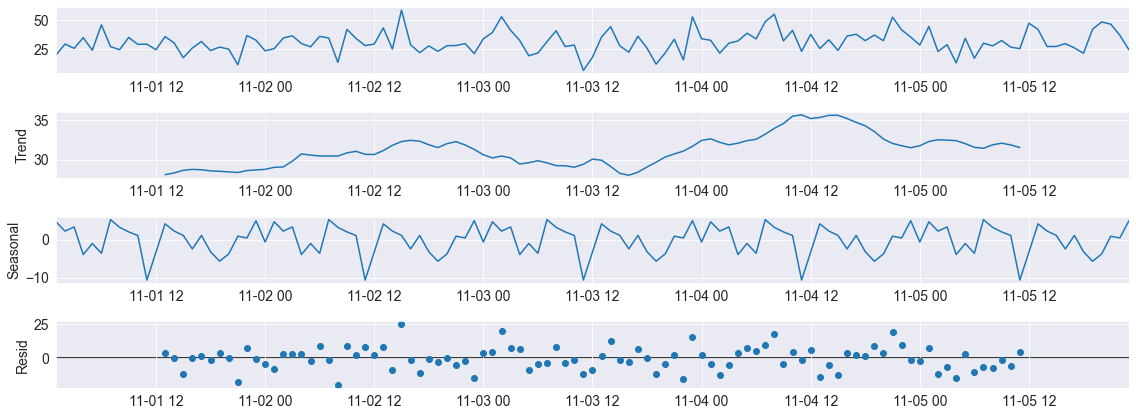

In [22]:
seas_dec = seasonal_decompose(TotSteamdata[1:120], model = "additive")
seas_dec.plot()
plt.show()

### ACF

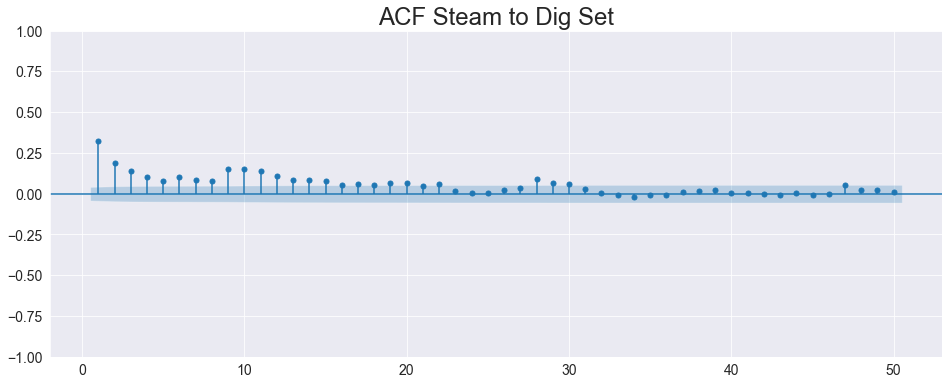

In [23]:
sgt.plot_acf(TotSteamdata, lags = 50, zero = False)
plt.title("ACF Steam to Dig Set", size = 24)
plt.show()

### PACF

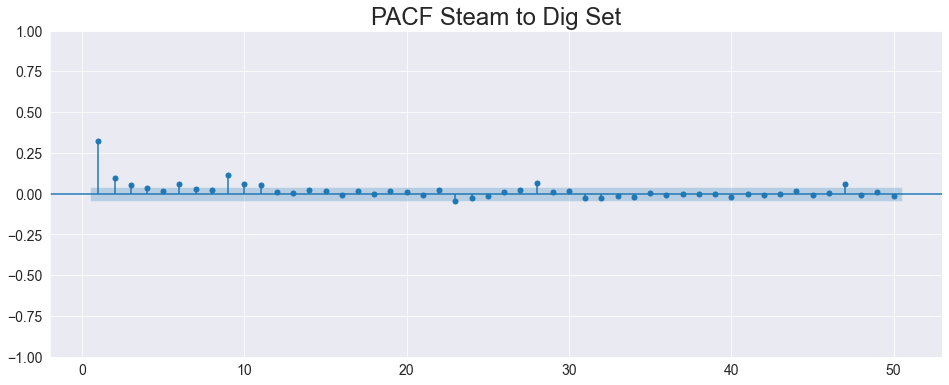

In [24]:
sgt.plot_pacf(TotSteamdata, lags = 50, zero = False, method = ('ols'))
plt.title("PACF Steam to Dig Set", size = 24)
plt.show()

In [25]:
# Spare copy
TotSteamdata_twin1 = TotSteamdata.copy()

### Data Split

In [26]:
train_size = int(len(TotSteamdata)*0.85)
val_size = train_size + int(len(TotSteamdata)*0.10)
train_TotSteam = TotSteamdata.iloc[:train_size]
val_TotSteam = TotSteamdata.iloc[train_size:val_size]
test_TotSteam = TotSteamdata.iloc[val_size:]

### Auto ARIMA Model

In [27]:
model_auto = auto_arima(train_TotSteam, max_order = None, max_p = 30, seasonality = True,
                       m = 24, maxiter = 100, alpha = 0.05, n_jobs = -1, trend = 'ct',)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [28]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -6917.797
Date:                Wed, 16 Mar 2022   AIC                          13845.595
Time:                        18:01:37   BIC                          13873.282
Sample:                             0   HQIC                         13855.794
                               - 1877                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.2691      2.347      6.932      0.000      11.669      20.869
drift       7.832e-05      0.000      0.257      0.797      -0.001       0.001
ar.L1          0.4868      0.074      6.601      0.000       0.342       0.631
ma.L1         -0.2496      0.083     -3.015      0.003      -0.412      -0.087
sigma2        93.0655      3.013     30.887      0.000      87.160      98.971
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                14.96
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.21
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### AR Model Residual Analysis

In [29]:
TotSteam_resid_dataset = train_TotSteam.copy()
TotSteam_resid_dataset['residuals'] = model_auto.resid()

In [30]:
print(TotSteam_resid_dataset.residuals.mean())
print(TotSteam_resid_dataset.residuals.var())

0.001293002461969045
93.10706001068596


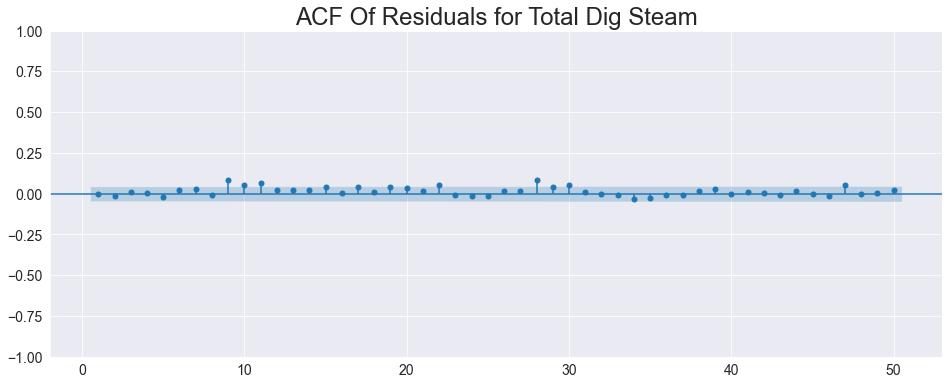

In [31]:
sgt.plot_acf(TotSteam_resid_dataset.residuals, zero = False, lags = 50)
plt.title("ACF Of Residuals for Total Dig Steam",size=24)
plt.show()

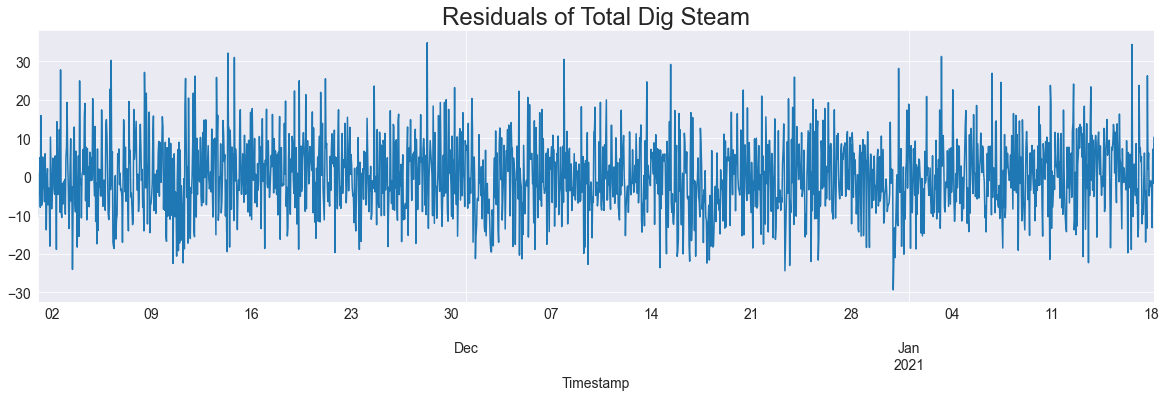

In [32]:
TotSteam_resid_dataset.residuals[1:].plot(figsize=(20,5))
plt.title("Residuals of Total Dig Steam",size=24)
plt.show()

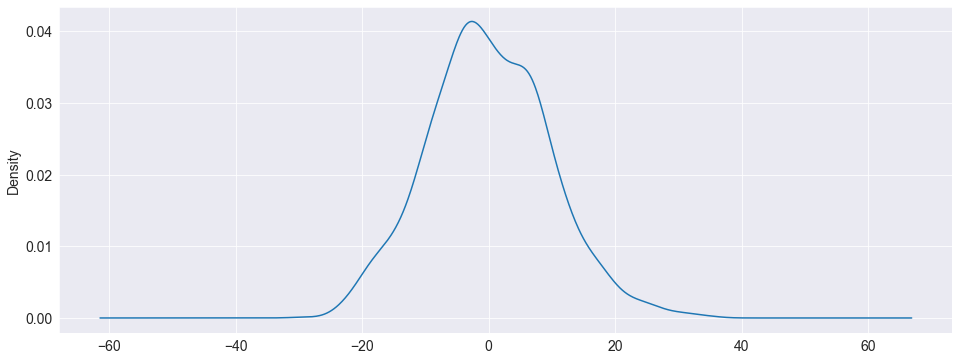

In [33]:
TotSteam_resid_dataset.residuals[1:].plot(kind='kde')
plt.show()

### Model Validation

In [34]:
start_date = "2021-01-18 05:00:00"
end_date = "2021-01-27 08:00:00"

In [35]:
df_pred = pd.DataFrame(model_auto.predict(n_periods = len(val_TotSteam),
                            index = val_TotSteam.index))

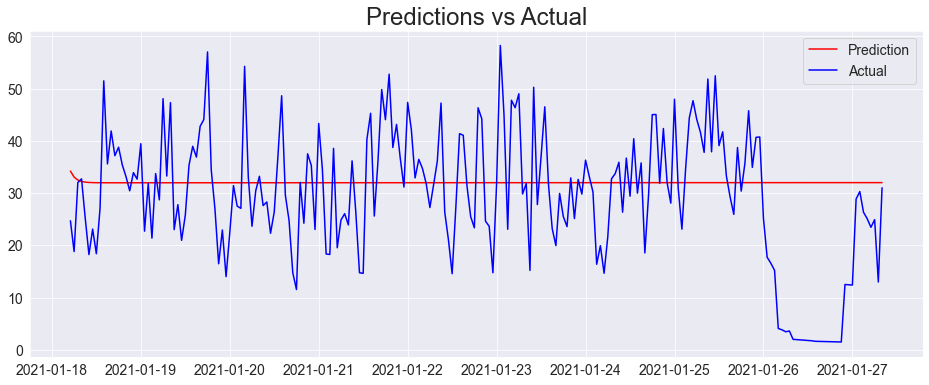

In [36]:
plt.plot(TotSteamdata[start_date:end_date].index.to_numpy(), df_pred[0], color = "red")
plt.plot(TotSteamdata[start_date:end_date].index, TotSteamdata[start_date:end_date].to_numpy(), color = "blue")
plt.legend(['Prediction', 'Actual'])
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Performance Metrics

In [37]:
ndapred, ndaactual = df_pred, val_TotSteam.to_numpy()

In [38]:
print(ndapred.shape)
print(ndaactual.shape)

(220, 1)
(220, 1)


In [39]:
print("MAE: %.4f" %mean_absolute_error(ndaactual, ndapred))
print("RMSE: %.4f" %np.sqrt(mean_squared_error(ndaactual, ndapred)))

MAE: 9.9722
RMSE: 12.9479


### Forecast

In [40]:
fcast = pd.DataFrame(model_auto.predict(n_periods = len(test_TotSteam), index = test_TotSteam.index))

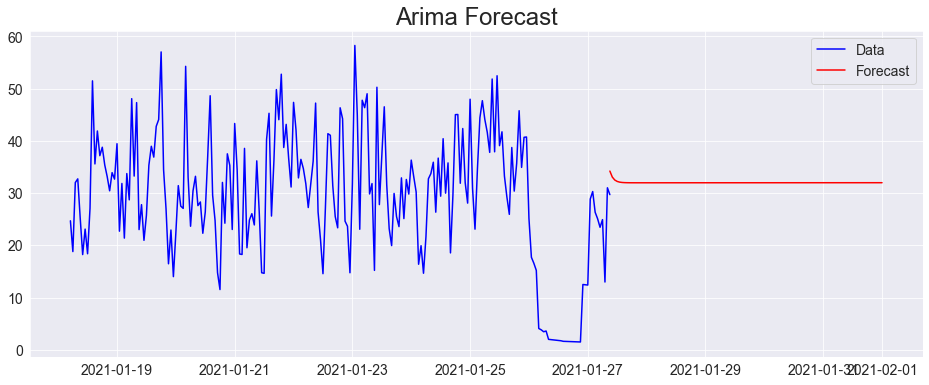

In [41]:
plt.plot(TotSteamdata.index[1877:2098], TotSteamdata[1877:2098].to_numpy(), color = "blue")
plt.plot(test_TotSteam.index, fcast[0], color = "red")
plt.legend(['Data', 'Forecast'])
plt.title("Arima Forecast", size = 24)
plt.show()